# About the project

Currently I am moving into Lyon, France for study. Classes will be at the district "ECULLY", so I want to map all districts of Lyon and segment them over two variables: distance to campus and trending venues.


## 1. Import libraries needed


In [31]:
import pandas as pd
import numpy as np
import pgeocode
import re
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import seaborn as sns
from sklearn import preprocessing
import folium
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

## 2. Downloading Lyons Metropolis list of Communes (or districts) and preraing the database


In [32]:
df_part1 = pd.read_html('https://en.wikipedia.org/wiki/Communes_of_the_Lyon_Metropolis')[1]
df_part2 = pd.read_html('https://en.wikipedia.org/wiki/Communes_of_the_Lyon_Metropolis')[2]
drop_list= ['INSEE code','index']
df = df_part1.append(df_part2)

We have fo fix a merged cell with Lyon commmune

In [33]:
df.loc[df['Commune'] == 'Lyon']

,INSEE code,Postal code,Commune
0,69123,690016900269003690046900569006690076900869009,Lyon


splitting the psotal code string it is needed

In [34]:
Lyon_Arr = pd.DataFrame(columns = df.columns)
Lyon_aux = re.findall('.....',df.loc[df['Commune'] == 'Lyon']['Postal code'].values[0])

Lyon_Arr['Postal code'] = Lyon_aux

for n in range(len(Lyon_aux)):
    Lyon_Arr['Commune'][n] = f"Lyon {n+1}"

df = df[df.Commune != 'Lyon']
df = df.append(Lyon_Arr)
df = df.reset_index()
df.drop(drop_list, axis = 1, inplace = True)


now we have it:

In [35]:
df.head(10

,Postal code,Commune
0,69250,Albigny-sur-Saône
1,69500,Bron
2,69270,Cailloux-sur-Fontaines
3,69300,Caluire-et-Cuire
4,69410,Champagne-au-Mont-d'Or
5,69260,Charbonnières-les-Bains
6,69390,Charly
7,69680,Chassieu
8,69660,Collonges-au-Mont-d'Or
9,69960,Corbas


## 3. Adding coordenates of each Commune and the distance to Ecully - Campus

In [30]:
nomi = pgeocode.Nominatim('fr')


lat = np.zeros(len(df))
long = np.zeros(len(df))

for k in range(len(df)):
    lat[k] = nomi.query_postal_code(df['Postal code'][k]).latitude
    long[k] = nomi.query_postal_code(df['Postal code'][k]).longitude

lat = pd.DataFrame(lat)
long = pd.DataFrame(long)



df['latitude']=lat
df['longitude']=long

df

KeyError: 11

EM LYON Postal Code is: 69130. So lets get its coordenates and query the distance from each commune

In [16]:
geodist = pgeocode.GeoDistance('fr')
distancias = pd.DataFrame(geodist.query_postal_code(df['Postal code'].astype(str).values,69130))
df['Distance'] = distancias
df.head()


,Postal code,Commune,latitude,longitude,Distance
0,69250,Albigny-sur-Saône,45.8782,4.834533,12.136730
1,69500,Bron,45.7333,4.916700,12.047306
2,69270,Cailloux-sur-Fontaines,45.8500,4.846833,9.824269
3,69300,Caluire-et-Cuire,45.7904,4.841100,5.343529
4,69410,Champagne-au-Mont-d'Or,45.7955,4.785700,2.193151


## 4. Plotting an inicial map in order to check that everything is going well

In [17]:
# create map and display it
Lyon_Lat = nomi.query_postal_code(69130).latitude
Lyon_Lon = nomi.query_postal_code(69130).longitude
Lyon_map = folium.Map(location=[Lyon_Lat, Lyon_Lon], zoom_start=12)

In [29]:
# instantiate a feature group for the incidents in the dataframe
arrondissement  = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(df['latitude'], df['longitude']):
    arrondissement.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
Lyon_map.add_child(arrondissement)

Good, we have a nice map of the Metropoli of Lyon. 

## 4. Quering FOURSQUARE the information regarding each commune

In [19]:
CLIENT_ID = 'T21N2TM2N3GQPTAWKL1EH4A5I5LXPQUIXLPVOYNKJ5NYZCCT' # your Foursquare ID
CLIENT_SECRET = 'HJTG3QZSEZQG2XMGAL33FRPYSEI14GWVJHU0O3JHAZW4VAIE' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30 # limit of number of venues returned by Foursquare API
radius = 100 # define radius
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: T21N2TM2N3GQPTAWKL1EH4A5I5LXPQUIXLPVOYNKJ5NYZCCT
CLIENT_SECRET:HJTG3QZSEZQG2XMGAL33FRPYSEI14GWVJHU0O3JHAZW4VAIE


In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)  
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Commune', 
                  'Commune Latitude', 
                  'Commune Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
lyon_venues = getNearbyVenues(names=df['Commune'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )

Albigny-sur-Saône
Bron
Cailloux-sur-Fontaines
Caluire-et-Cuire
Champagne-au-Mont-d'Or
Charbonnières-les-Bains
Charly
Chassieu
Collonges-au-Mont-d'Or
Corbas
Couzon-au-Mont-d'Or
Craponne
Curis-au-Mont-d'Or
Dardilly
Décines-Charpieu
Écully
Feyzin
Fleurieu-sur-Saône
Fontaines-Saint-Martin
Fontaines-sur-Saône
Francheville
Genay
Givors
Grigny
Irigny
Jonage
Limonest
Lissieu
Marcy-l'Étoile
Meyzieu
Mions
Montanay
La Mulatière
Neuville-sur-Saône
Oullins
Pierre-Bénite
Poleymieux-au-Mont-d'Or
Quincieux
Rillieux-la-Pape
Rochetaillée-sur-Saône
Saint-Cyr-au-Mont-d'Or
Saint-Didier-au-Mont-d'Or
Sainte-Foy-lès-Lyon
Saint-Fons
Saint-Genis-Laval
Saint-Genis-les-Ollières
Saint-Germain-au-Mont-d'Or
Saint-Priest
Saint-Romain-au-Mont-d'Or
Sathonay-Camp
Sathonay-Village
Solaize
Tassin-la-Demi-Lune
La Tour-de-Salvagny
Vaulx-en-Velin
Vénissieux
Vernaison
Villeurbanne
Lyon 1
Lyon 2
Lyon 3
Lyon 4
Lyon 5
Lyon 6
Lyon 7
Lyon 8
Lyon 9


Now we will count how many Venues are in each commune and add the information to the main DataFame (df). In order to focus, we will work with communes those distances are below 10 kms and theirs numbers of venues are higher than 3. 

In [36]:
A = lyon_venues.groupby('Commune').count()
for name in df['Commune']:
    if name in A.index:
        df.loc[df['Commune'] == name, 'N_Venues'] = A['Commune Latitude'][name]

df.dropna(subset = ["N_Venues"], inplace=True)
df_new = df.drop(df[(df['Distance'] > 10) | (df['N_Venues'] < 3)].index)
df_new.head()

KeyError: 'Distance'

## 5. Plotting into 2 Dim plot, in order "to see" the clusters

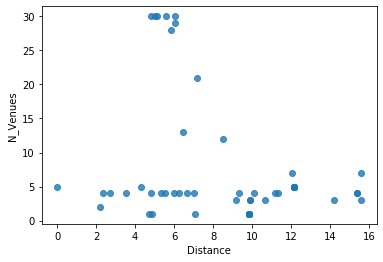

In [25]:
sns.regplot(x=df_new["Distance"], y=df_new["N_Venues"], fit_reg=False)

In [26]:
# set number of clusters
kclusters = 3

lyon_clustering = df_new.drop(['Commune','Postal code','latitude','longitude'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(lyon_clustering)

# check cluster labels generated for each row in the dataframe
df_new['Cluster'] = kmeans.labels_

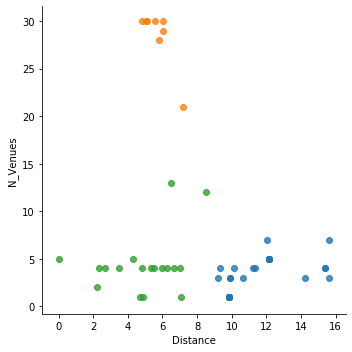

In [27]:
sns.lmplot(x="Distance", y="N_Venues", data=df_new, hue='Cluster', fit_reg=False, legend=False)

Three cluster are seggregated. Theirs difference are mainly the number of venues around  of the yellow cluster, and between green and blue is the distance to campus.

In [37]:
# create map
map_clusters = folium.Map(location=[Lyon_Lat, Lyon_Lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ['blue','orange','green']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_new['latitude'], df_new['longitude'], df_new['Commune'], df_new['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=rainbow[cluster],
        popup=label,
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

It could be seen, that the central communes belong to the same cluster because they have the same number of venues and the same distance to campus. Then, you have the outside communs that don't have many venues and the longest distance. And finally, the middles one that don't have as many venues as the centrals but theirs distance is reasonable. 

In [38]:
df_new.loc[df_new['Cluster'] == 1]

,Postal code,Commune,latitude,longitude,Distance,N_Venues,Cluster
58,69001,Lyon 1,45.7485,4.84060,6.025724,29.0,1
59,69002,Lyon 2,45.7542,4.83880,5.589557,30.0,1
60,69003,Lyon 3,45.7612,4.84925,6.045785,30.0,1
61,69004,Lyon 4,45.7751,4.83690,4.822339,30.0,1
62,69005,Lyon 5,45.7611,4.83675,5.131656,30.0,1
63,69006,Lyon 6,45.7679,4.84865,5.822354,28.0,1
65,69008,Lyon 8,45.7485,4.85770,7.184053,21.0,1
66,69009,Lyon 9,45.7485,4.82500,5.041822,30.0,1
